## Pregunta 18 de Examen Final

### Instrucciones:

In relation to the book of Gujarati (basic econometrics), answer question 22.11 pp 799: Consider the data on log DPI (personal disposable income) introduced in Section 21.1 (see the book's website for the current data). Suppose you want to fit a suitable ARIMA model to these data. Outline the steps involved in carrying out this task

### Funciones re-utilizables

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Reusable functions
# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("INTERPRETATION:")
    if adf_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")

    # KPSS Test
    kpss_result = kpss(series)
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("INTERPRETATION:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Function to find best ARIMA model with interpretation
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("INTERPRETATION:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")
    return best_order

# Plot detailed forecast with confidence intervals and interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = model.forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    forecast_index = range(len(series), len(series) + steps)

    plt.figure(figsize=(12,6))
    plt.plot(series, label=f'{name} Historical')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink',
                    alpha=0.3,
                    label='95% Confidence Interval')
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Print forecast values
    print(f"\n{name} Forecast Values (next 5 periods):")
    print(forecast[:5])

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")
    print("Interpretation: The wider the confidence interval, the less certain the forecast")

# Function to plot correlograms with interpretation
def plot_correlograms(series, name, lags=30):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title(f'ACF for {name}')
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title(f'PACF for {name}')
    plt.tight_layout()
    plt.show()
    print(f"\nCorrelogram Interpretation for {name}:")
    print("  - ACF: Shows total correlation at each lag, including indirect effects")
    print("  - PACF: Shows direct correlation at each lag, controlling for earlier lags")
    print("  - Significant spikes outside the blue confidence interval suggest strong correlations")
    print("  - ACF decay pattern indicates potential ARIMA model orders")
    print("  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order")

Los pasos que se deben seguir para encontrar el ARIMA con los mejores parámetros son los siguientes:

1. Revisar estacionariedad con Raiz Unitaria
2. Revisar estacionariedad con Correlogramas
3. Determinación de parámetros para el modelo
4. Entreamiento del modelo
5. Evaluación de los resultados
6. Graficación de la predicción



## Recopilar data

In [ ]:
df = pd.read_excel('EF18.xlsx')
df = df["DPI"]
df.dropna(inplace=True)
df

,DPI
1,0.014711
2,0.012397
3,-0.000049
4,0.013935
5,0.011554
...,...
83,-0.004946
84,-0.004174
85,0.006409
86,0.000706


## 1. Revisar Estacionariedad

### 1.1 Prueba de Raiz Unitaria

In [ ]:
unit_root_tests(df, "dpi")


Unit Root Tests for dpi:
ADF Test:
ADF Statistic: -4.6692
p-value: 0.0001
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - dpi is stationary

KPSS Test:
KPSS Statistic: 0.1970
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
INTERPRETATION:
  - p-value >= 0.05: Fail to reject null - dpi may be stationary


La hipótesis nula de la prueba ADF establece que la serie tiene una raíz unitaria (no es estacionaria), mientras que la hipótesis nula de la prueba KPSS plantea que la serie es estacionaria alrededor de una tendencia determinista. Por esta razón, es común que una de ellas rechace su hipótesis nula mientras la otra no lo haga; sin embargo, ambas pueden conducir a la misma conclusión.

**ADF TEST**
Dado que el p-value de 0.0001 es menor que el nivel de significancia (α = 0.05) y el estadístico ADF de −4.6692 es más extremo (más negativo) que los valores críticos usuales (1%, 5% y 10%), se rechaza la hipótesis nula de raíz unitaria. En consecuencia, se asume que la serie DPI es estacionaria y no requiere diferenciación adicional para el modelado ARIMA (d = 0).

**KPS TEST**
El p-value de 0.10 (≥ 0.05) y el estadístico KPSS de 0.1970 está por debajo de los valores críticos para 10%, 5%, 2.5% y 1%, por lo que no se rechaza la hipótesis nula de estacionariedad. Esto es consistente con la lectura de la ADF: la serie dpi se comporta como estacionaria.

Ambas pruebas concluyen que la serie es estacionaria.

### 1.2 Correlogramas

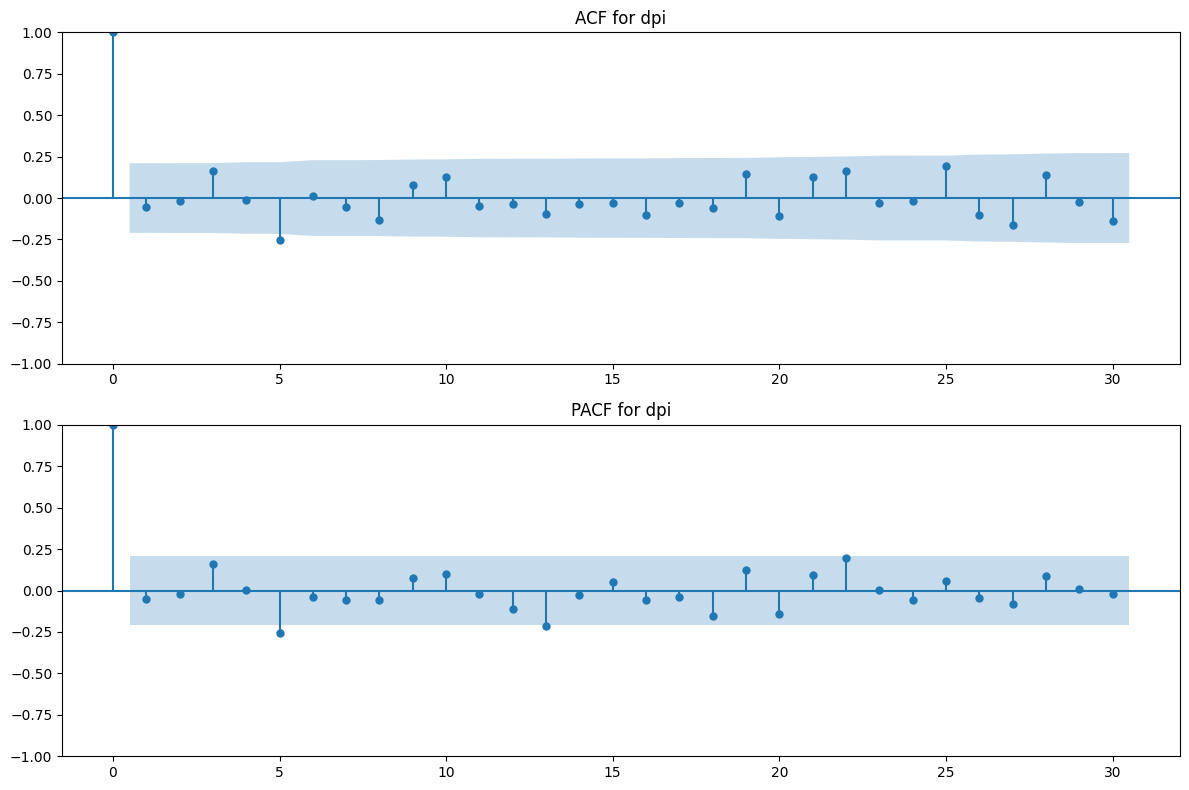


Correlogram Interpretation for dpi:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


In [ ]:
plot_correlograms(df, "dpi")

**ACF**
Las barras del ACF caen con rapidez y permanecen dentro de las bandas de confianza tras los primeros retrasos. Este patrón es consistente con una serie estacionaria y sin tendencia evidente, con poca persistencia en la autocorrelación. El pico que sobrepasa las bandas indica una correlación puntual estadísticamente significativa, pero no se observa un decaimiento lento y sostenido que sugiera no estacionariedad o la necesidad de diferenciar.

**PACF**
El PACF muestra pocos rezagos con señal moderada, y a partir de ahí las barras caen de manera abrupta y se mantienen dentro de las bandas. Este comportamiento indica ausencia de una estructura AR fuerte. Por lo tanto, el PACF respalda lo visto en el ACF: la serie no exige diferenciar.

## 3. Determinar los mejores parámetros para el modelo


In [ ]:
best_arima = find_best_arima(df, "dpi")


Best ARIMA model for dpi:
Order: (0, 0, 0)
AIC: -541.74
INTERPRETATION:
  - p=0: 0 autoregressive term(s)
  - d=0: 0 difference(s) needed for stationarity
  - q=0: 0 moving average term(s)


Tomando en cuenta los resultados de las pruebas de raiz unitaria y los correlogramas, se busca mediante la función find_best_arima la mejor combinación de hiperparámetros para los términos AR y MA. El barrido arrojó como mejor especificación un ARIMA(0,0,0) con AIC de −541.74. Por lo tanto, añadir términos AR o MA no mejora el ajuste lo suficiente como para compensar la penalización del AIC.

In [ ]:
model = ARIMA(df, order=best_arima)

## 4. Entrenamiento el modelo

In [ ]:
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    DPI   No. Observations:                   87
Model:                          ARIMA   Log Likelihood                 272.868
Date:                Sun, 02 Nov 2025   AIC                           -541.737
Time:                        21:45:14   BIC                           -536.805
Sample:                             0   HQIC                          -539.751
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.001      5.859      0.000       0.004       0.009
sigma2         0.0001   1.18e-05      9.384      0.000    8.74e-05       0.000
Ljung-Box (L1) (Q):                   0.25   Jarque-

El modelo presenta un intercepto estadísticamente significativo en 0.0066. El proceso oscila alrededor de una media constante, con un crecimiento promedio del 0.66% por periodo.

Con AIC = −541.737, BIC = −536.805 y HQIC = −539.751, se respalda que no existe ganancia significativa en agregar términos AR o MA al modelo.

**Ljung-Box**
La prueba de autocorrelación con Q = 0.25 y p = 0.62 indica que no existe evidencia de autocorrelación en el primer rezago, esto quiere decir que los residuos se comportan como ruido blanco en el corto plazo.

**Jarque-Bera**
La prueba da un resultado de 16.46 con p = 0.00. Esto quiere decir que los residuos no siguen una normal perfecta, con ligera asimetría positiva y colas más pesadas. Por lo tanto, se rechaza normalidad.

**Heterocedasticidad**
H = 0.41 con p = 0.02. Esto da indicios de varianza no constante. Por lo tanto, si interesara modelar la volatilidad, podría considerarse un componente GARCH.


El modelo captura bien una media estable y no deja estructura serial explotable en los residuos. En proyección, los pronósticos se alinean con el intercepto y las bandas se amplían con el horizonte por la acumulación de incertidumbre.

## 5. Evaluación de resultados (forecast)

In [ ]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

In [ ]:
last_index = len(df) - 1
forecast_index = range(last_index + 1, last_index + 1 + forecast_steps)

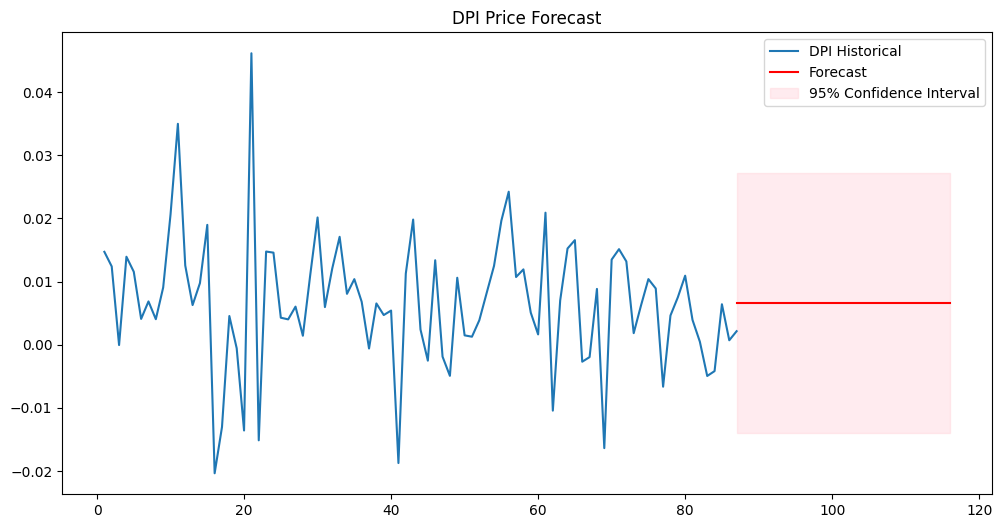


DPI Forecast Values (next 5 periods):
87    0.006637
88    0.006637
89    0.006637
90    0.006637
91    0.006637
Name: predicted_mean, dtype: float64

Forecast Interpretation for DPI:
Last observed value: 0.00
Average forecast value: 0.01
Forecast change: 0.00
Trend: Upward forecast trend
95% CI range at period 30: [-0.01, 0.03]
Interpretation: The wider the confidence interval, the less certain the forecast


In [ ]:
plot_forecast(model_fit, df, "DPI", forecast_steps)

El modelo seleccionado mantiene la complejidad al mínimo y, frente a alternativas con términos AR o MA, no obtiene mejoras sustantivas en criterios de información. Es un punto de referencia limpio y estable.

## Conclusión

El comportamiento de la serie es estable y con dependencia temporal limitada, por lo que un ARIMA corto resulta adecuado. El modelo estimado captura la media con eficacia y no deja señales de autocorrelación residual; sus limitaciones provienen de la no-normalidad y la heterocedasticidad detectadas, que invitan a ser cautelosos con los intervalos.

Como línea base para proyección y comparación, este modelo es sólido; si el objetivo es afinar la incertidumbre, el siguiente paso natural es incorporar un tratamiento explícito de la varianza o intervalos robustos.